#Load raw_data from csv

In [1]:
%pylab
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import pandas as pd
from IPython.html.widgets import *
from scipy.signal import filtfilt, butter
from scipy.signal import resample

Using matplotlib backend: MacOSX
Populating the interactive namespace from numpy and matplotlib


:0: FutureWarning: IPython widgets are experimental and may change in the future.


In [3]:
df = pd.read_csv('./S1Ach3.csv', header=None)
raw_data = df.values[:,df.values[0,:]==1.0]
print raw_data.shape
df.head(10)

(900, 36)


,0,1,2,3,4,5,6,7,8,9,...,65,66,67,68,69,70,71,72,73,74
0,0,0.73635,0,161.00,1.000,113.320,1.000,159.70,1.000,139.45,...,478.48,1.000,301.00,1.000,351.93,1.000,1003.40,1.000,634.00,1.000
1,1,0.73635,46105,196.32,1.099,170.400,1.201,192.50,1.093,139.80,...,566.27,1.084,255.72,0.919,304.30,0.927,971.00,0.984,668.55,1.027
2,2,0.73635,46485,160.59,0.930,115.080,0.866,207.28,1.111,150.90,...,528.25,1.007,281.55,1.008,342.07,1.028,990.05,1.002,708.10,1.057
3,3,0.73635,46864,120.95,0.757,58.947,0.515,204.40,1.070,145.72,...,491.38,0.952,303.73,1.064,368.48,1.078,1064.80,1.057,701.33,1.034
4,4,0.73635,47245,185.51,1.125,140.260,1.173,123.47,0.696,143.70,...,481.98,0.946,292.80,1.020,396.65,1.125,1100.00,1.072,776.70,1.113
5,5,0.73635,47625,163.56,0.993,133.180,1.093,155.22,0.893,91.90,...,420.23,0.850,259.88,0.920,313.07,0.905,963.73,0.949,762.85,1.077
6,6,0.73635,48005,157.95,0.965,116.110,0.959,172.72,0.995,187.80,...,445.52,0.914,271.12,0.965,353.25,1.018,936.17,0.932,723.50,1.018
7,7,0.73635,48390,170.41,1.036,116.840,0.970,157.43,0.917,145.38,...,567.33,1.141,337.32,1.172,311.32,0.909,1029.50,1.022,708.17,0.997
8,8,0.73635,48765,168.73,1.023,85.816,0.736,172.00,1.002,112.17,...,534.12,1.065,262.82,0.922,296.15,0.878,968.40,0.965,702.42,0.990
9,9,0.73635,49145,158.46,0.964,119.500,1.022,126.12,0.755,125.62,...,547.50,1.082,250.53,0.889,343.93,1.017,1017.90,1.013,631.90,0.900


In [4]:
fs = 1.0/320/1e-3; dt = 1.0/fs; T = len(raw_data)*dt
rt = linspace(0,T,len(raw_data))
data = raw_data

#Filtering and dynamically display the trace

In [5]:
# Create an order 3 bandpass butterworth filter.
def butter_bandpass(lowcut, highcut, fs, order=3):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def peakdet(v, delta, x = None):
    maxtab = []
    mintab = []
    if x is None:
        x = arange(len(v))
    v = asarray(v)
    mn, mx = Inf, -Inf
    mnpos, mxpos = NaN, NaN
    lookformax = True
    for i in arange(len(v)):
        this = v[i]
        if this > mx:
            mx = this
            mxpos = x[i]
        if this < mn:
            mn = this
            mnpos = x[i]
        if lookformax:
            if this < mx-delta:
                maxtab.append((mxpos, mx))
                mn = this
                mnpos = x[i]
                lookformax = False
        else:
            if this > mn+delta:
                mintab.append((mnpos, mn))
                mx = this
                mxpos = x[i]
                lookformax = True
    return array(maxtab), array(mintab)

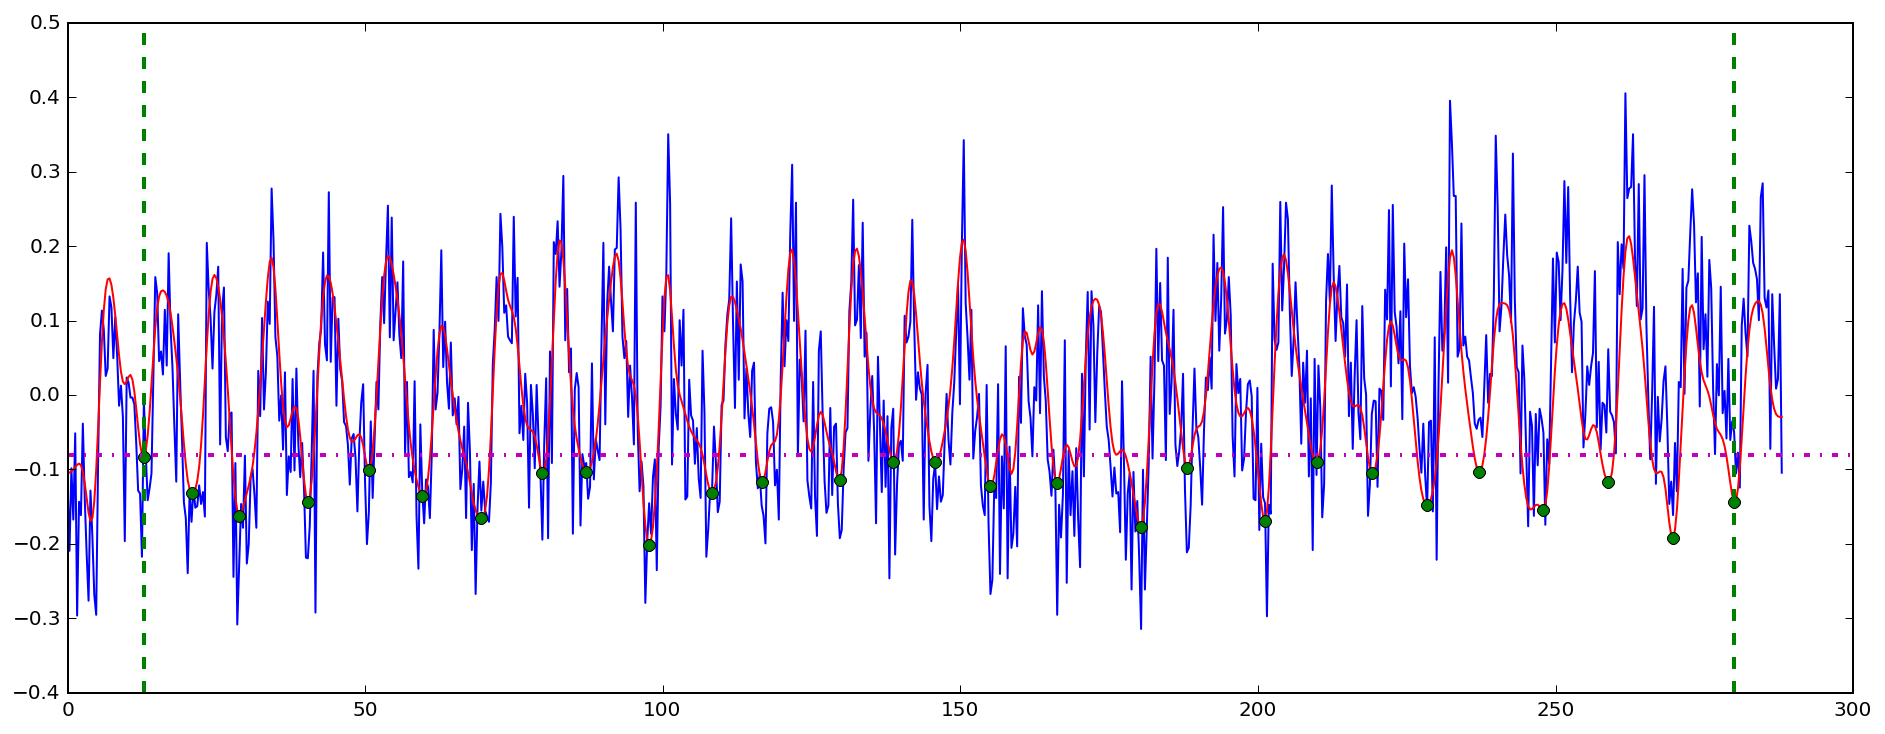

In [6]:
@interact(i=(0,data.shape[1]-1,1))
def show_trace(i=0):
    fig = figure(figsize=(16, 6), dpi=100, facecolor='w', edgecolor='b')
    ax = fig.add_subplot(111)
    x = data[:,i]
    x = x-mean(x)
    b, a = butter_bandpass(0.01,0.3,fs)
    global idx
    global t
    global y
    global thr2
    idx = i
    y = filtfilt(b, a, x, padlen=150, padtype="even")  #pad method is very important in this case
    maxidx, minidx = peakdet(y,0.1,rt)
    ax.plot(rt,x,rt,y,'r')
    ax.plot(minidx[:,0],minidx[:,1],'go')
    ax.axvline(minidx[0,0],ls='--',lw=2,c='g')
    ax.axvline(minidx[-1,0],ls='--',lw=2,c='g')
    thr2 = median(minidx[:,1]*0.675)
    ax.axhline(thr2,ls='-.',lw=2,c='m')
    condition = np.logical_and(rt>=minidx[0,0], rt<=minidx[-1,0])
    t = rt[condition]
    y = y[condition]
    return fig

#Amplitude Threshold

In [5]:
def get_cross(y, thr):
    cr = zeros(size(y))
    for i in arange(len(y)-1):
        if y[i]<thr and y[i+1]>=thr:
#             print 'cross_up'
            cr[i] = 1
        elif y[i]>=thr and y[i+1]<thr:
#             print 'cross_down'
            cr[i] = -1
    return cr

def get_epoch(y, thr1, thr2):
    cr = get_cross(y,thr2)
    up_start = np.asarray(where(cr==1)).reshape(-1,)
    up_end = np.asarray(where(cr==-1)).reshape(-1,)
    epoch = np.hstack((up_start.reshape(-1,1), up_end.reshape(-1,1)))
    epoch_final = []
    for epo in epoch:
        if any(y[epo[0]:epo[1]]>thr1):
            epoch_final.append(epo)
    epoch_final = asarray(epoch_final)
    return epoch_final

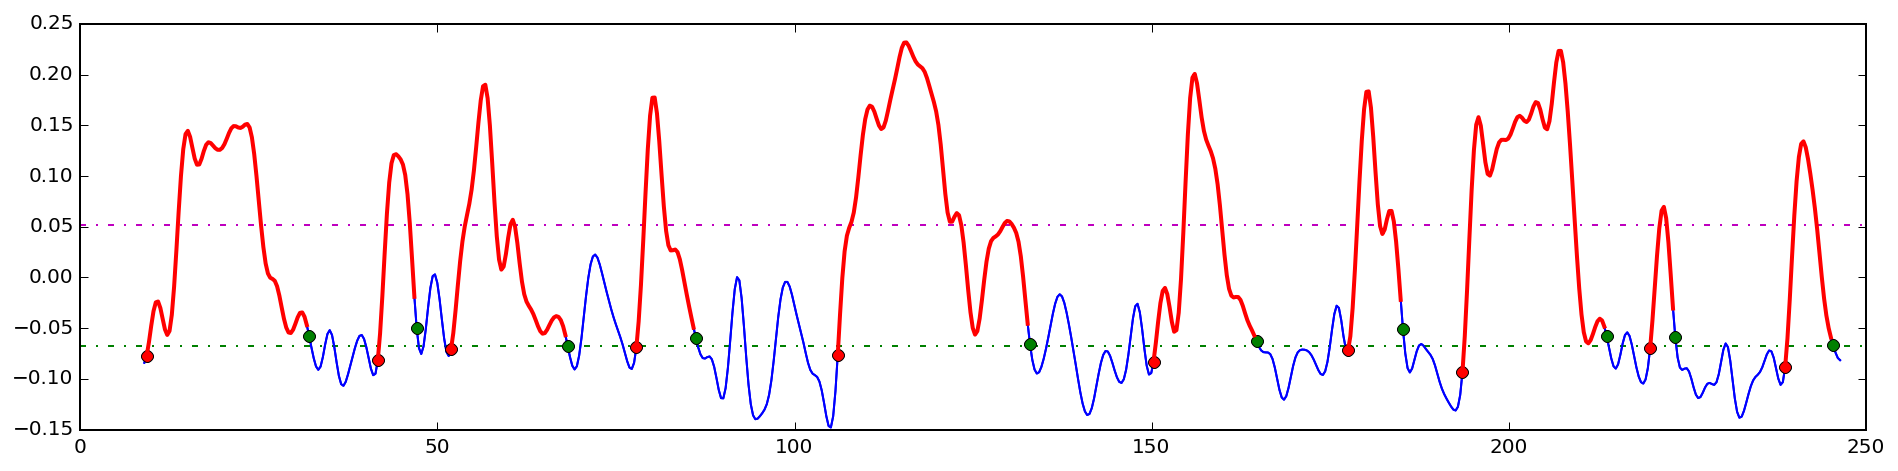

In [6]:
@interact(thr1=(min(y),max(y),0.02), thr2=(min(y),max(y),0.02))
def get_up_down(t=fixed(t),y=fixed(y),thr1=median(abs(y)/0.675),thr2=0):
    # calculate epoch
    global epoch
    epoch = get_epoch(y,thr1,thr2)
    # plot
    fig = figure(figsize=(16, 8), dpi=50, facecolor='w', edgecolor='b')
    ax1 = fig.add_subplot(211)
    ax1.plot(t,y)
    ax1.axhline(thr1,ls='-.',c='m')
    ax1.axhline(thr2,ls='-.',c='g')
    ax1.plot(t,y,'b',t[epoch[:,0]],y[epoch[:,0]],'ro',t[epoch[:,1]],y[epoch[:,1]],'go')
    for epo in epoch:
        ax1.plot(t[epo[0]:epo[1]],y[epo[0]:epo[1]],'r-',lw=2)

#     ax2 = fig.add_subplot(212)
#     ax2.plot(t,ud,'g')
#     ax2.plot(t[epoch],ud[epoch],'ro', markersize=4)
#     ax2.set_ylim([min(ud)-0.1,max(ud)+0.1])

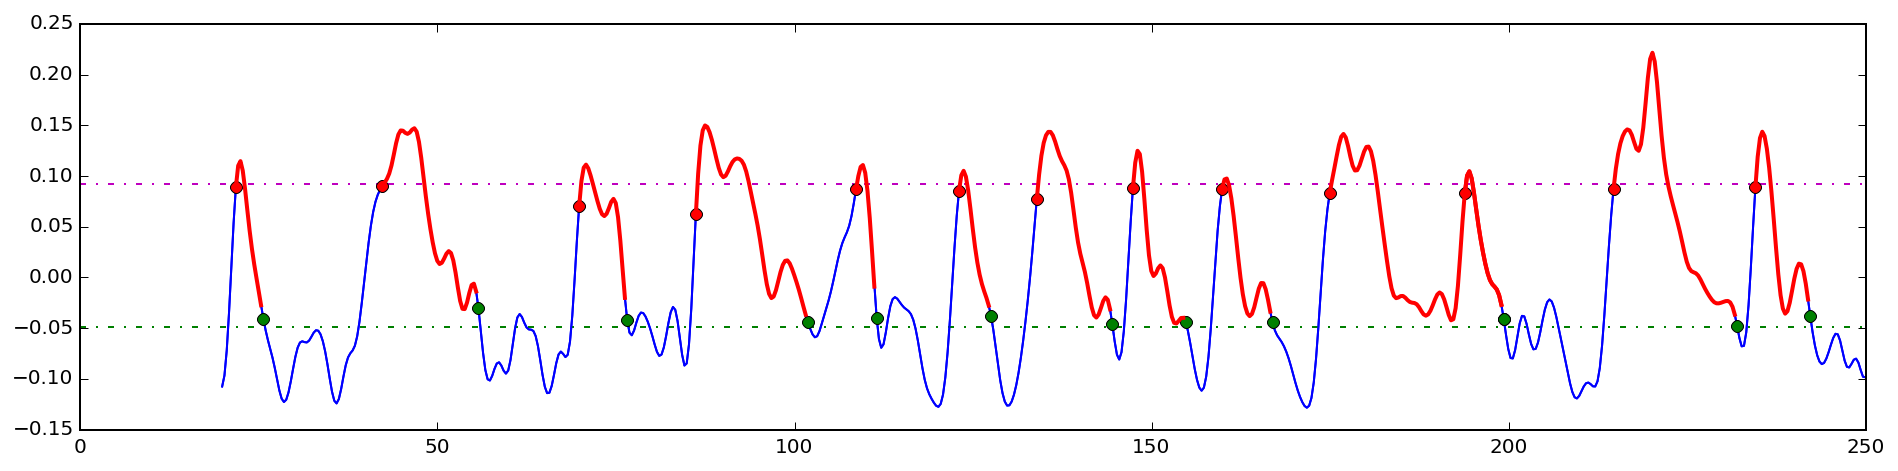

In [381]:
# def get_cross(y, thr1, thr2):
#     cr = zeros(size(y))
#     for i in arange(len(y)-1):
#         if y[i]<thr1 and y[i+1]>=thr1:
# #             print 'cross_up'
#             cr[i] = 1
#         elif y[i]>=thr2 and y[i+1]<thr2:
# #             print 'cross_down'
#             cr[i] = -1
#     return cr

# def get_epoch(y, thr1, thr2):
#     cr = get_cross(y,thr1,thr2)
#     up_start = np.asarray(where(cr==1)).reshape(-1,)
#     up_end = np.asarray(where(cr==-1)).reshape(-1,)
#     time_diff = np.zeros((size(up_end), size(up_start)))
#     down_idx = np.zeros(size(up_start),dtype=int)
#     up = up_start
#     for k, end in enumerate(up_end):
#         time_diff[k,:] = end - up_start
#     for j, d in enumerate(time_diff.T):
#         down_idx[j] = where(d>0)[0][0]
#     down = up_end[down_idx]
#     epoch = np.hstack((up.reshape(-1,1), down.reshape(-1,1)))
#     return epoch

# @interact(thr1=(min(y),max(y),0.02), thr2=(min(y),max(y),0.02))
# def get_up_down(t=fixed(t),y=fixed(y),thr1=median(abs(y)/0.675),thr2=0):
#     # calculate epoch
#     global epoch
#     epoch = get_epoch(y,thr1,thr2)
#     # plot
#     fig = figure(figsize=(16, 8), dpi=50, facecolor='w', edgecolor='b')
#     ax1 = fig.add_subplot(211)
#     ax1.plot(t,y)
#     ax1.axhline(thr1,ls='-.',c='m')
#     ax1.axhline(thr2,ls='-.',c='g')
#     ax1.plot(t,y,'b',t[epoch[:,0]],y[epoch[:,0]],'ro',t[epoch[:,1]],y[epoch[:,1]],'go')
#     for epo in epoch:
#         ax1.plot(t[epo[0]:epo[1]],y[epo[0]:epo[1]],'r-',lw=2)





#     ax2 = fig.add_subplot(212)
#     ax2.plot(t,ud,'g')
#     ax2.plot(t[epoch],ud[epoch],'ro', markersize=4)
#     ax2.set_ylim([min(ud)-0.1,max(ud)+0.1])

#Duration threshold

In [7]:
def plot_upstates(t,y,epoch,duration_thr=0):
    fig = figure(figsize=(16, 8), dpi=50, facecolor='w', edgecolor='b')
    ax1  = fig.add_subplot(211)
    ax1.plot(t,y,'b',lw=2)
    ud = zeros(size(t))
    for epo in epoch:
        du = epo[1] - epo[0]
        if du <= duration_thr:
            ax1.plot(t[epo[0]:epo[1]],y[epo[0]:epo[1]],'go',lw=2)
        else:
            ax1.plot(t[epo[0]:epo[1]],y[epo[0]:epo[1]],'r-',lw=2)
            ud[epo[0]:epo[1]] = 1
    ax2  = fig.add_subplot(212)
    ax2.plot(t,y,'b',t,ud,'r')
    return fig

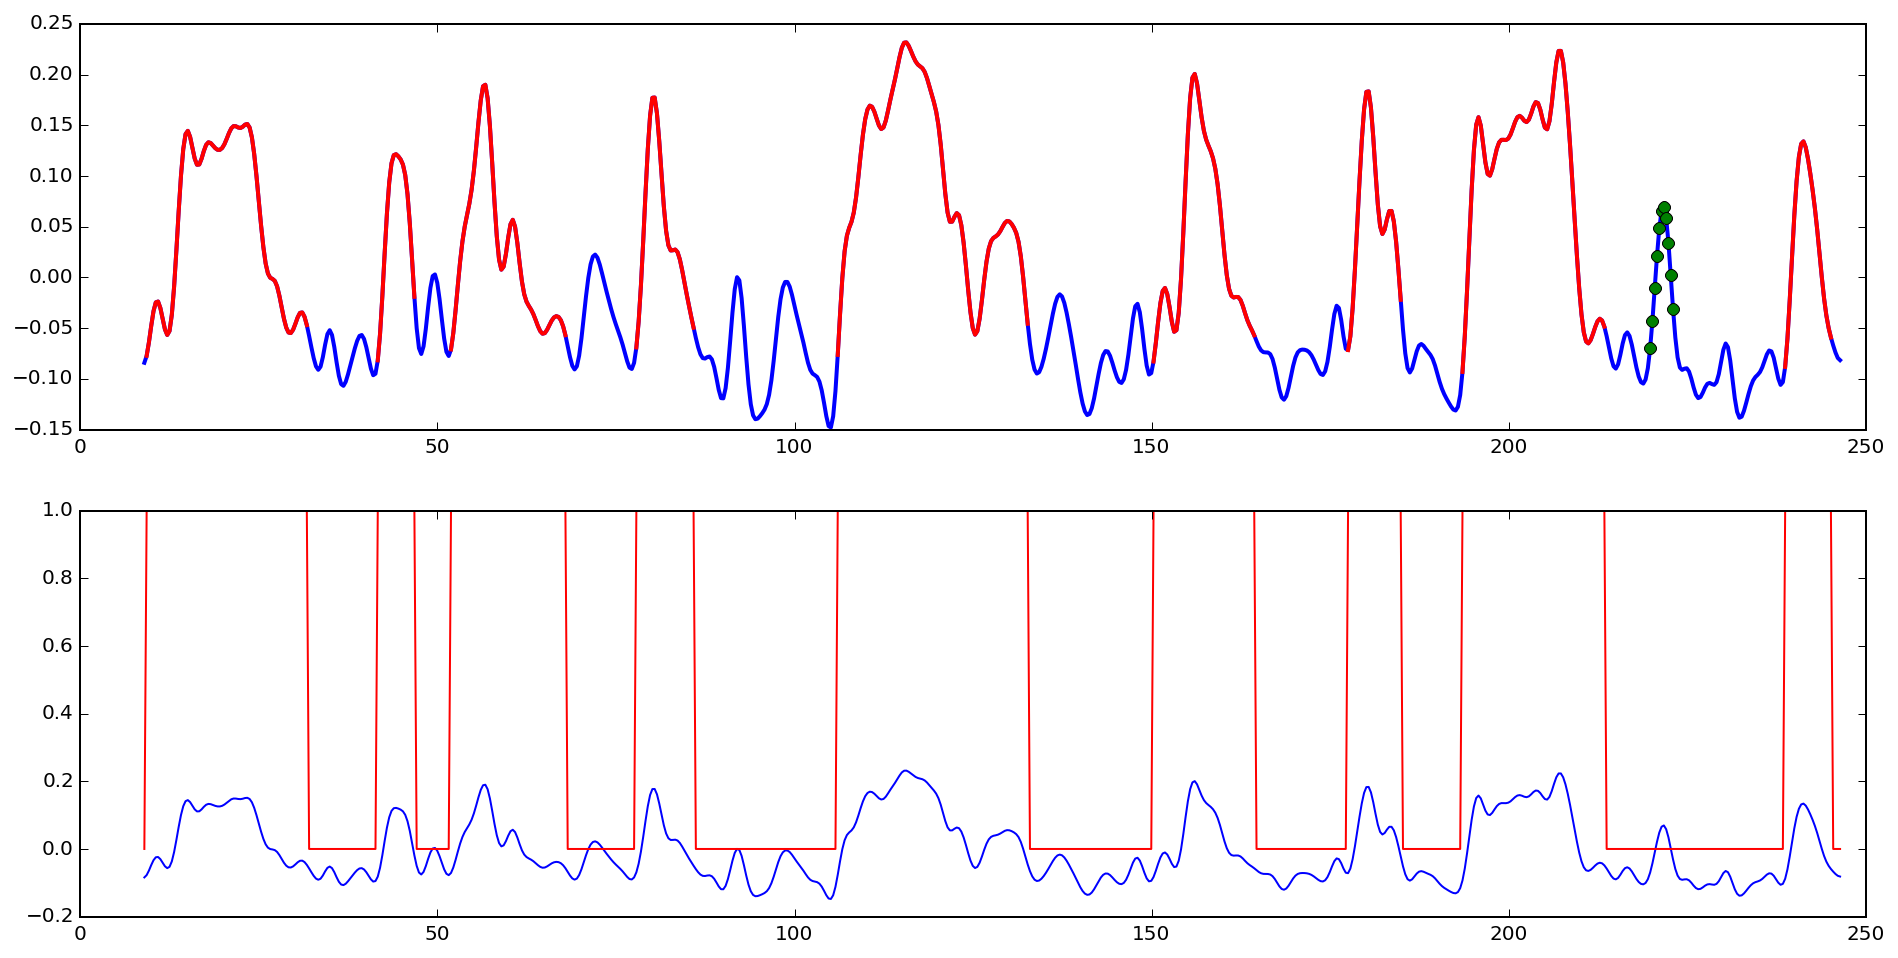

In [9]:
@interact(duration_thr=(0,20,1))
def get_upstates(duration_thr=0, epoch=fixed(epoch)):
    global fig
    fig = plot_upstates(t,y,epoch,duration_thr)
    condition = epoch[:,1]-epoch[:,0] > duration_thr
    epoch = epoch[condition,:]
    global epoch_
    epoch_ = epoch

In [10]:
fname = 'optical'+str(idx)+'.pdf'
fig.savefig(fname, bbox_inches='tight')
!open .

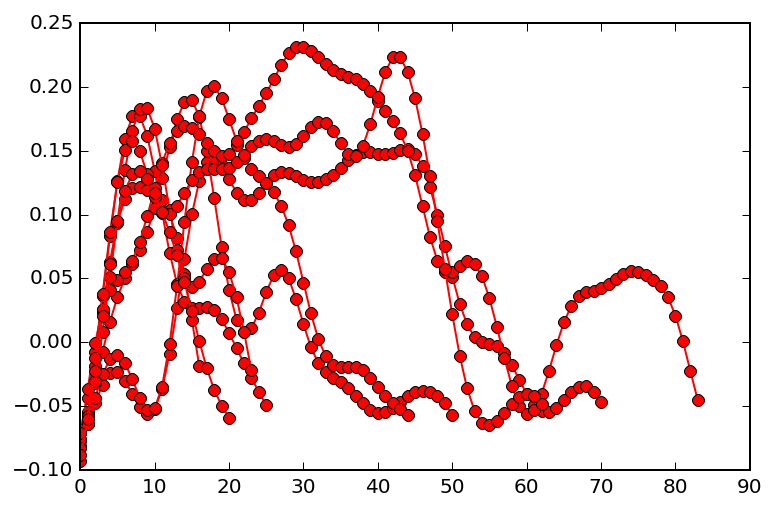

In [11]:
fig = figure()
for epo in epoch_:
    plot(y[epo[0]:epo[1]],'r-o')

In [12]:
fig.savefig('test.pdf', bbox_inches='tight')
!open .

In [19]:
from scipy.stats import mode
duration = epoch_[:,1] - epoch_[:,0]
print duration
duration = mean(duration/fs)
print duration
print idx

[71 17 51 26 84 45 24 63 21]
14.2933333333
49


#Save and load results

In [28]:
def plot_upstates(t,y,epoch,duration_thr=0):
    fig = figure(figsize=(16, 8), dpi=50, facecolor='w', edgecolor='b')
    ax1  = fig.add_subplot(211)
    ax1.plot(t,y,'b',lw=2)
    ud = zeros(size(t))
    for epo in epoch:
        du = epo[1] - epo[0]
        if du <= duration_thr:
            ax1.plot(t[epo[0]:epo[1]],y[epo[0]:epo[1]],'go',lw=2)
        else:
            ax1.plot(t[epo[0]:epo[1]],y[epo[0]:epo[1]],'r-',lw=2)
            ud[epo[0]:epo[1]] = 1
    ax2  = fig.add_subplot(212)
    ax2.plot(t,y,'b',t,ud,'r')
    return fig

In [20]:
save(str(idx),(idx,t,y,epoch_,duration))
!open .

In [2]:
idx,u,v,n,d = load('./49.npy')

In [3]:
n

array([[  1,  72],
       [102, 119],
       [134, 185],
       [215, 241],
       [303, 387],
       [441, 486],
       [526, 550],
       [576, 639],
       [717, 738]])

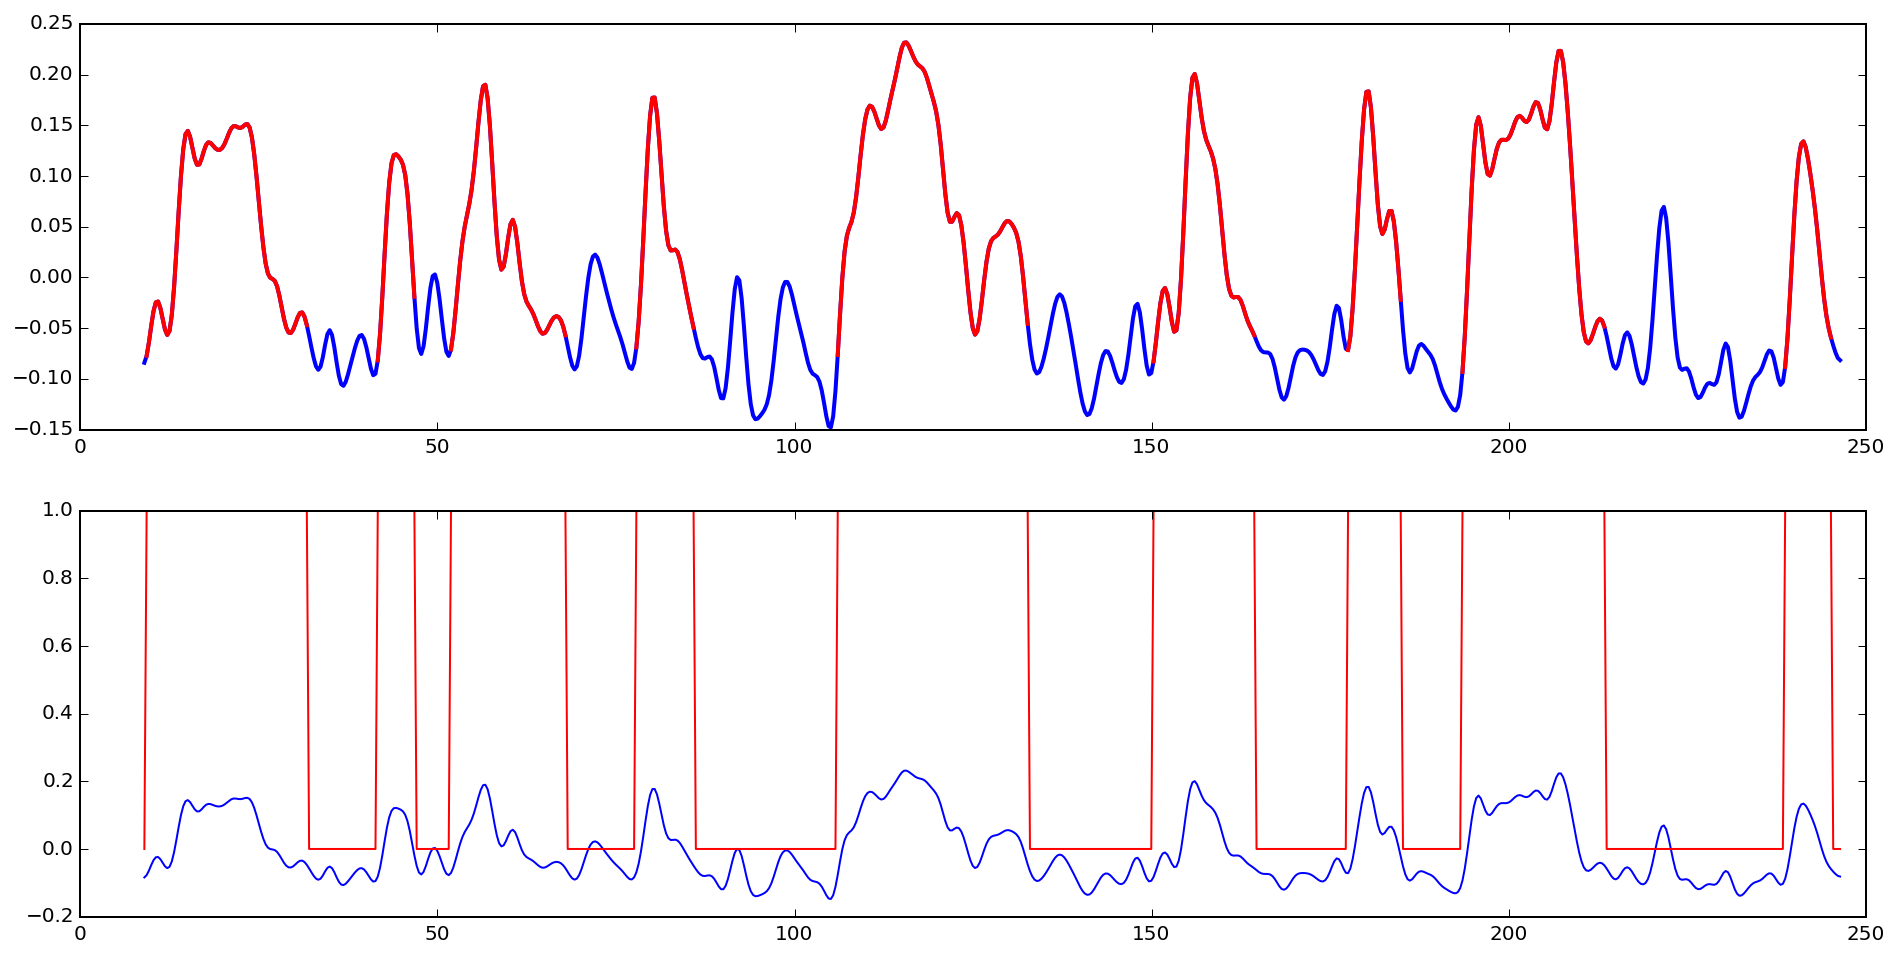

In [6]:
fig = plot_upstates(u,v,n)

In [28]:
fname = 'plot' + str(idx) + '.pdf'
fig.savefig(fname)
!open .

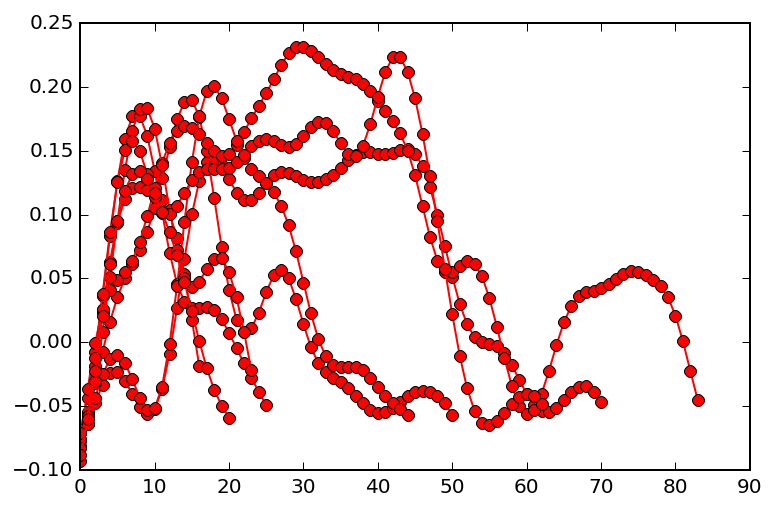

In [29]:
for epo in n:
    plot(v[epo[0]:epo[1]],'r-o')

In [7]:
!open .

#Batch

In [1]:
!ls

11.pdf                                 ctrl1.csv
27.npy                                 ctrl1.xlsx
27.pdf                                 optical49.pdf
49.npy                                 plot49.pdf
60.pdf                                 sig_process_up_down_states-Copy1.ipynb
Ach1-1.csv                             sig_process_up_down_states.ipynb
Ach1-1.xlsx                            test.pdf
S1Ach3.csv                             upstatesduration.pdf


In [21]:
f = !ls | grep npy

In [22]:
f

['27.npy', '49.npy']

In [23]:
f[1]

'49.npy'

In [31]:
t,y,epoch,duration = load(f[1])

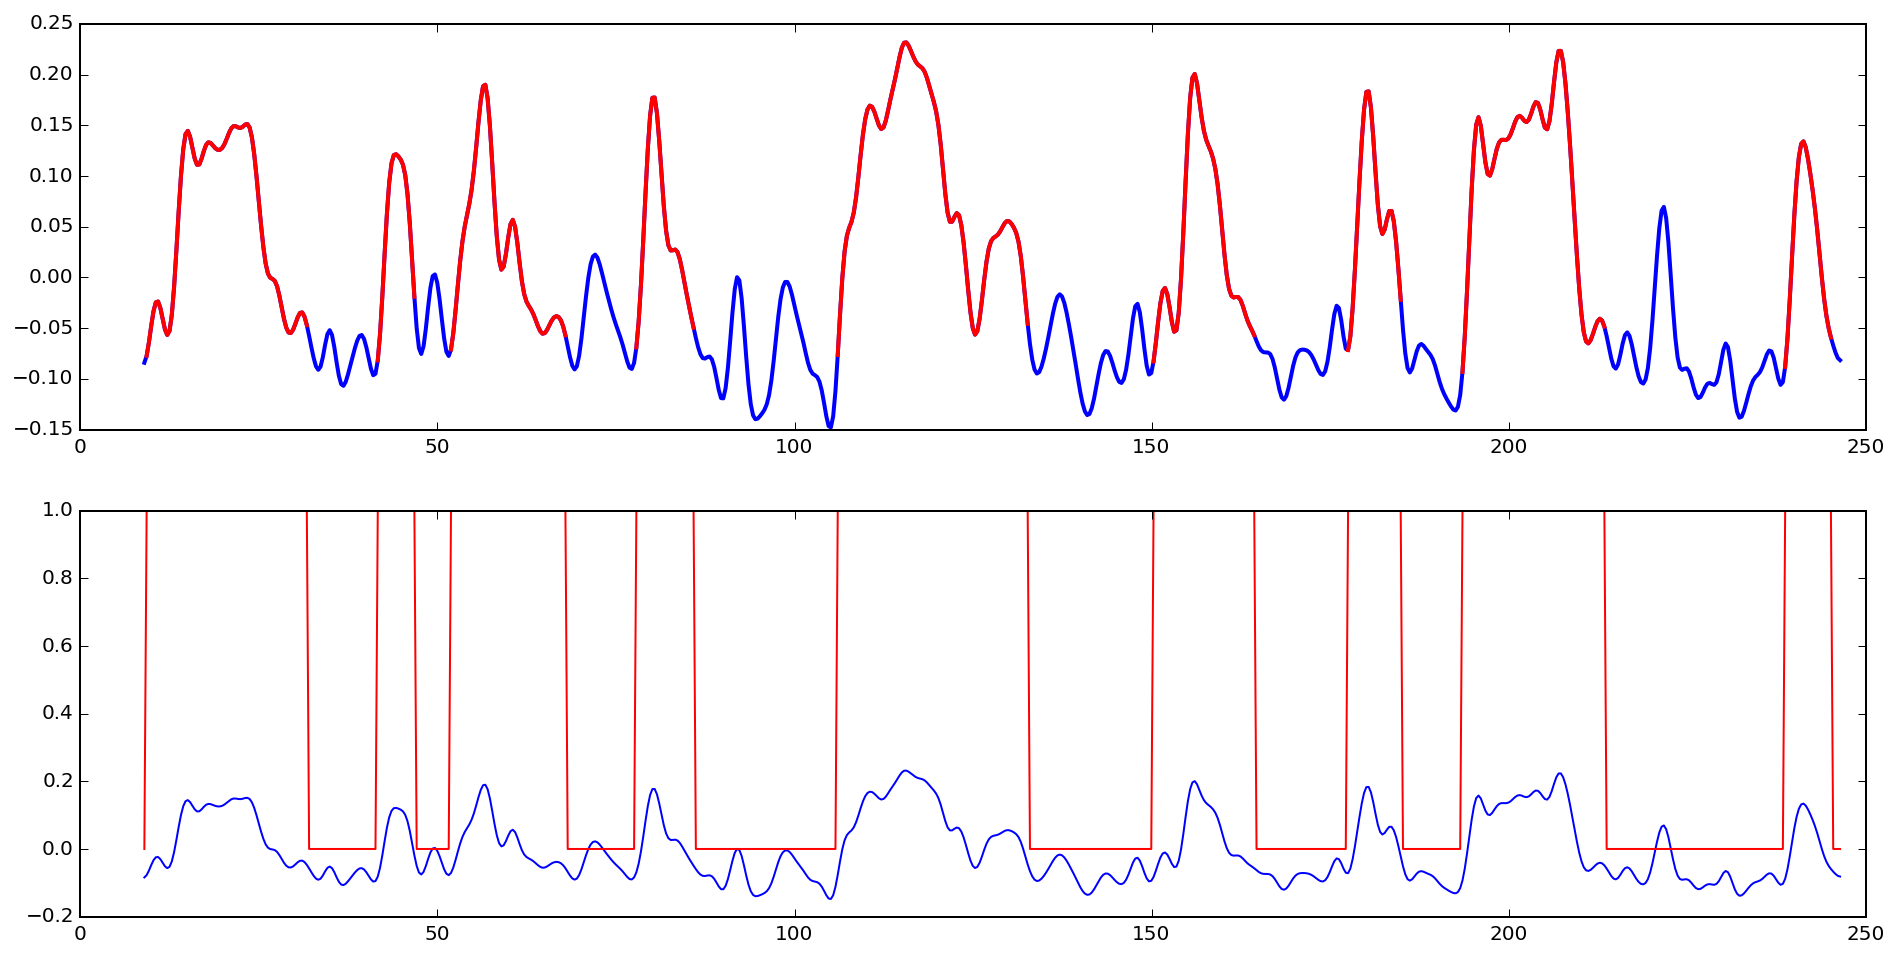

In [32]:
fig = plot_upstates(t,y,epoch)

In [33]:
d = []

In [34]:
d

[]

In [35]:
d.append(2.3)

In [36]:
d

[2.3]

In [37]:
d.append(4.5)

In [38]:
d

[2.3, 4.5]

In [39]:
d.append(8.9)

In [40]:
d

[2.3, 4.5, 8.9]

In [41]:
d = asarray(d)

In [42]:
d

array([ 2.3,  4.5,  8.9])

In [43]:
d.shape

(3,)

In [48]:
d = d.reshape(-1,1)

In [49]:
d

array([[ 2.3],
       [ 4.5],
       [ 8.9]])

In [50]:
x1 = np.array([1,2,3,4,5])
x2 = np.array([2,3,4,5,6])

In [63]:
x1

array([1, 2, 3, 4, 5])

In [68]:
x1.shape

(5,)

In [69]:
x1_ = x1.reshape(1,-1)
x1_.shape

(1, 5)

In [65]:
x = np.vstack((x1, x2))

In [66]:
x

array([[1, 2, 3, 4, 5],
       [2, 3, 4, 5, 6]])

In [59]:
x.T

array([[1, 2],
       [2, 3],
       [3, 4],
       [4, 5],
       [5, 6]])